# Large experiment for HPL on Dahu

In [1]:
import io
import zipfile
import pandas
from plotnine import *
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_result(name):
    archive = zipfile.ZipFile(name)
    return pandas.read_csv(io.BytesIO(archive.read('results.csv')))

df = pandas.concat([
    read_result('grenoble_2018-10-10_1811810.zip'),
    read_result('grenoble_2018-10-10_1811847.zip'),
])
df.head()

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


,bcast,block_size,depth,gflops,matrix_size,mem_align,pfact,proc_p,proc_q,process_per_node,residual,rfact,swap,thread_per_process,time
0,2,128,1,17540.0,75000,8,1,32,32,32,0.000928,2,0,1,16.03
1,2,128,1,23290.0,225000,8,1,32,32,32,0.000612,2,0,1,326.05
2,2,128,1,22260.0,175000,8,1,32,32,32,0.000827,2,0,1,160.53
3,2,128,1,20990.0,125000,8,1,32,32,32,0.000793,2,0,1,62.02
4,2,128,1,23630.0,250000,8,1,32,32,32,0.000563,2,0,1,440.78


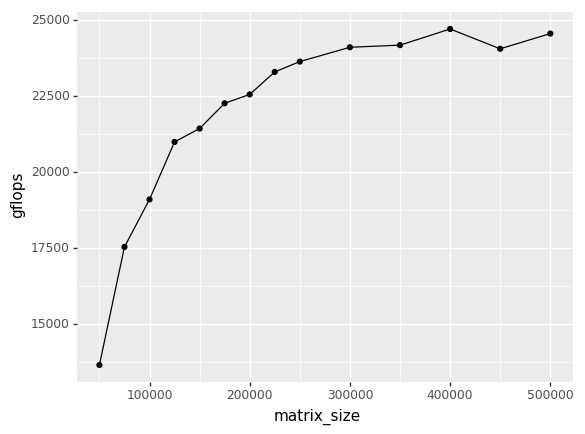

<ggplot: (8751372488389)>

In [2]:
ggplot(df, aes(x='matrix_size', y='gflops')) + geom_line() + geom_point()

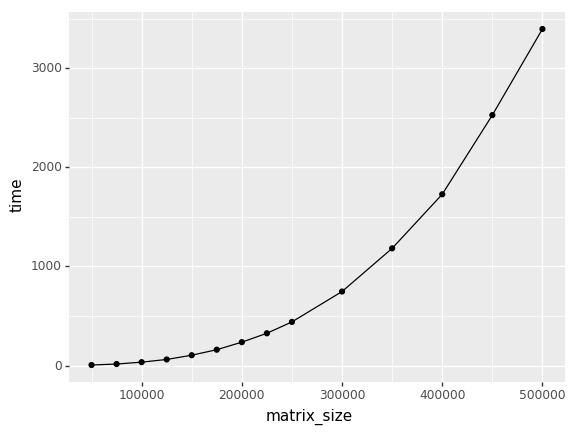

<ggplot: (8751372452798)>

In [3]:
ggplot(df, aes(x='matrix_size', y='time')) + geom_line() + geom_point()

In [4]:
df[df.gflops == df.gflops.max()]

,bcast,block_size,depth,gflops,matrix_size,mem_align,pfact,proc_p,proc_q,process_per_node,residual,rfact,swap,thread_per_process,time
2,2,128,1,24700.0,400000,8,1,32,32,32,0.000531,2,0,1,1727.64


## Extrapolation

Used to determine the walltime of the jobs I submit on G5K.

HPL time complexity is $\mathcal{O}\left(\frac{2}{3}n^3 + 2n^2\right)$

[source](https://en.wikipedia.org/wiki/LINPACK_benchmarks#LINPACK_100)

In [5]:
import statsmodels.formula.api as sm
reg = sm.ols(data=df, formula='time ~ I(matrix_size**3) + I(matrix_size**2)').fit()
reg.summary()

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.234e+04
Date:                Wed, 10 Oct 2018   Prob (F-statistic):           4.70e-24
Time:                        16:33:52   Log-Likelihood:                -55.962
No. Observations:                  14   AIC:                             115.9
Df Residuals:                      12   BIC:                             117.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1.522e-20   6.19e-21      2.459      0.030    1.74e-21    2.87e-20
I(matrix_size ** 3)  2.628e-14   4.42e-16     59.449      0.000    2.53e-14    2.72e-14
I(matrix_size ** 2)   4.76e-10   1.94e-10      2.459      0.030    5.43e-11    8.98e-10
==============================================================================
Omnibus:                        6.474   Durbin-Watson:                   2.596
Prob(Omnibus):                  0.039   Jarque-Bera (JB):                4.178
Skew:                           0.177   Prob(JB):                        0.124
Kurtosis:                       5.653   Cond. No.                     9.57e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.57e+16. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [6]:
tmp = df[['matrix_size', 'time', 'gflops']].copy()
tmp['mode'] = 'real'
tmp2 = pandas.DataFrame([{'matrix_size': n, 'time':-1} for n in range(100, 1000000, 100)])
tmp2['time'] = reg.predict(tmp2)
tmp2['mode'] = 'extrapolation'
tmp2['gflops'] = ((2/3)*tmp2.matrix_size**3 + 2*tmp2.matrix_size**2) / tmp2.time * 1e-9
tmp = pandas.concat([tmp, tmp2])

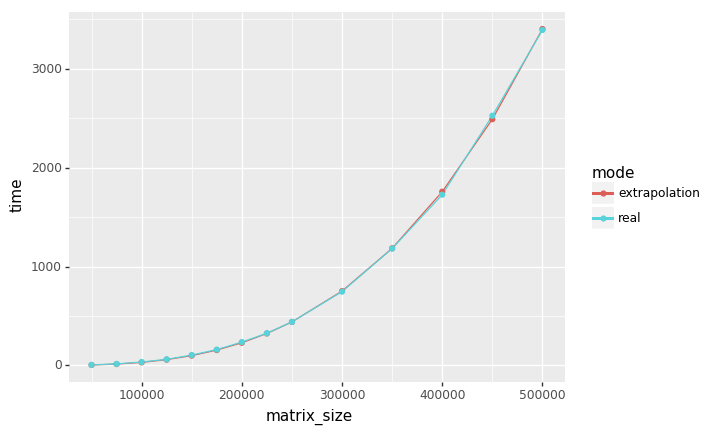

<ggplot: (8751370226710)>

In [7]:
ggplot(tmp[tmp.matrix_size.isin(df.matrix_size)], aes(x='matrix_size', y='time', color='mode')) + geom_line() + geom_point()

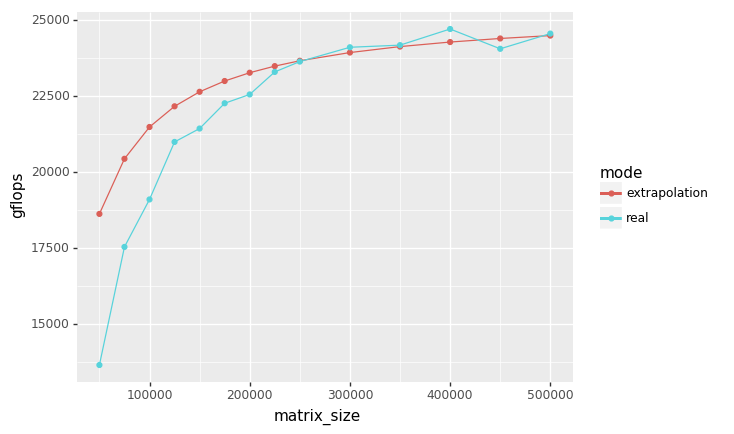

<ggplot: (8751370040019)>

In [8]:
ggplot(tmp[tmp.matrix_size.isin(df.matrix_size)], aes(x='matrix_size', y='gflops', color='mode')) + geom_line() + geom_point()

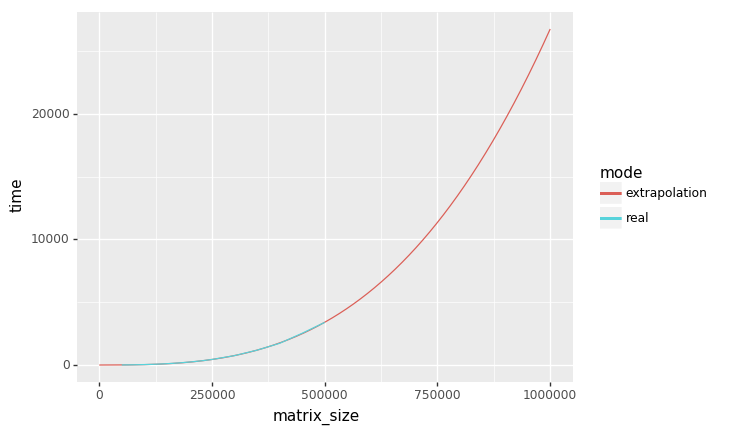

<ggplot: (8751370207117)>

In [9]:
ggplot(tmp, aes(x='matrix_size', y='time', color='mode')) + geom_line()

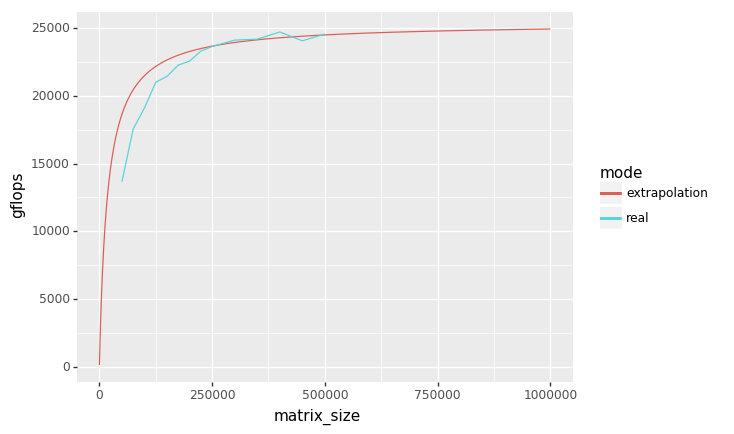

<ggplot: (8751370251994)>

In [10]:
ggplot(tmp, aes(x='matrix_size', y='gflops', color='mode')) + geom_line()

In [11]:
def time_to_str(time):
    h = time//3600
    time -= h*3600
    m = time//60
    time -= m*60
    s = time
    return '%02d:%02d:%02d' % (h, m, s)

def estimate(df, sizes):
    tmp = df[df.matrix_size.isin(sizes)]
    time = int(tmp.time.sum())
    print(time_to_str(time))
    return time
    
sizes_real = tmp[tmp['mode'] == 'real'].matrix_size
estimate(tmp[tmp['mode'] == 'real'], sizes_real)

03:02:45


10965

In [12]:
time_to_str(df.time.sum())

'03:02:45'

In [13]:
estimate(tmp[tmp['mode'] == 'extrapolation'], sizes_real)

03:02:25


10945

In [14]:
estimate(tmp[tmp['mode'] == 'extrapolation'], range(300000, 500001, 50000))

02:39:49


9589